# **Movie Recommendation System**

Recommender systems are essential for websites or online stores with millions of items, helping users find what they're looking for by narrowing down their choices. These systems are widely used by companies like Netflix and Amazon to suggest content tailored to individual users.

Our goal is to build a Collaborative Filtering-based Movie Recommendation System. The system will predict how a user would rate a movie they haven’t watched yet, and we aim to minimize the difference between predicted and actual ratings using metrics like RMSE (Root Mean Squared Error).

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

!pip install scikit-surprise

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

import seaborn as sns

**1. Data Collection**

In [ ]:
# Load and prepare the data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

**2. Data Cleaning**

In [ ]:
# Initialize the Reader object with the rating scale
reader = Reader(rating_scale=(1, 5))

# Checking for duplicates
print("No. of duplicates records in the dataset : ", ratings.columns.duplicated().sum())

# Checking the columns' titles and datatypes
ratings.info()

# Checking the number of missing values in data
ratings.isna().sum()

# Checking the columns' titles and datatypes
movies.info()

# Checking the number of missing values in data
movies.isna().sum()

# Checking the feature "userId"
total_users = ratings["userId"].nunique()
print(f"The count of unique userId in the dataset is: {total_users}")

# Checking the feature "movieId"
total_movies = movies["movieId"].nunique()
print(f"The count of unique movieId in the dataset is: {total_movies}")

No. of duplicates records in the dataset :  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
The count of unique userId in the dataset is: 138493
The count of unique movieId in the dataset is: 27278


**3. EXPLORATORY DATA ANALYSIS**

<ipython-input-82-2a0b5aed3d47>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")
<ipython-input-82-2a0b5aed3d47>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([changing_labels(num) for num in y_ticks])


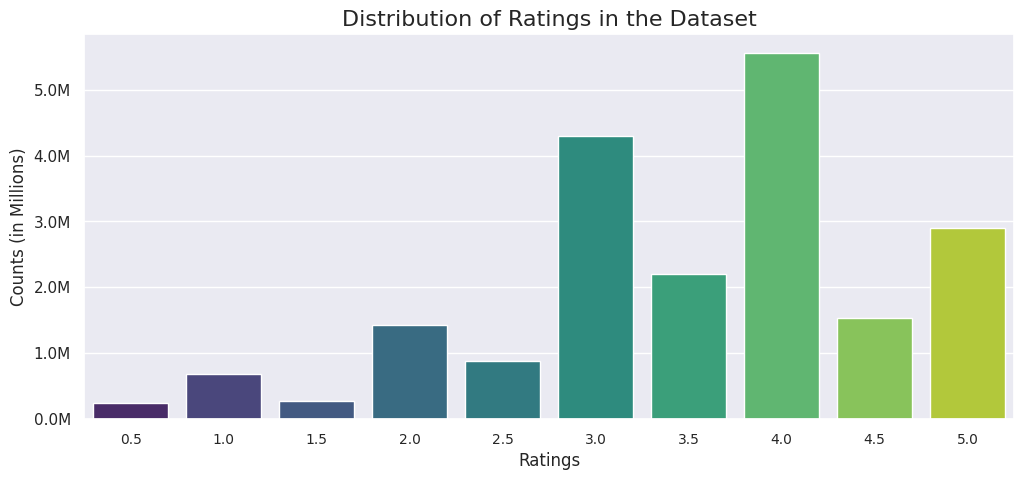

In [ ]:
# Helper function to change the numeric label in terms of Millions
def changing_labels(number):
    return f"{number / 10**6:.1f}M"

# Checking the feature "rating"
sns.set(style="darkgrid")
plt.figure(figsize=(12, 5))  # Adjusted for memory and usability
sns.countplot(x="rating", data=ratings, palette="viridis")

y_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([changing_labels(num) for num in y_ticks])
plt.title("Distribution of Ratings in the Dataset", fontsize=16)
plt.xlabel("Ratings", fontsize=12)
plt.ylabel("Counts (in Millions)", fontsize=12)
plt.xticks(fontsize=10)
plt.show()

The count of unique titles in the dataset is: 27262


<ipython-input-83-99956ffcb994>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_genres.index, y=unique_genres.values, palette="viridis")


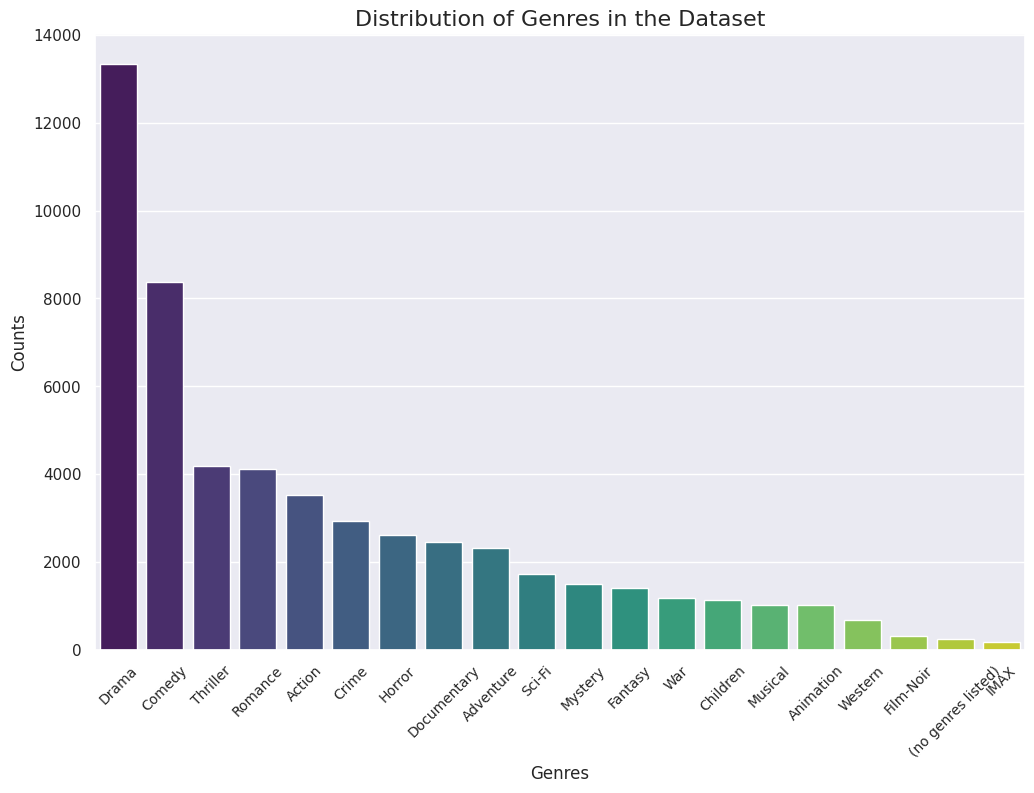

In [ ]:
# Checking the feature "title"
unique_titles = movies["title"].nunique()
print(f"The count of unique titles in the dataset is: {unique_titles}")

# Extract unique Genres and their count
genres_series = movies["genres"].str.split("|").explode()
unique_genres = genres_series.value_counts()

# Visualizing the feature "Genres"
plt.figure(figsize=(12, 8))  # Adjusted for memory
sns.barplot(x=unique_genres.index, y=unique_genres.values, palette="viridis")
plt.title("Distribution of Genres in the Dataset", fontsize=16)
plt.xlabel("Genres", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.show()

**4. Train and Test Splitting**

In [ ]:
# Load the dataset into the format required by scikit-surprise
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

**5. Model Building & Fitiing**

In [ ]:
# Initialize the SVD model for collaborative filtering
model = SVD()

In [ ]:
# Train the model on the training set
model.fit(trainset)
# Make predictions on the test set
predictions = model.test(testset)

In [ ]:
# Calculate RMSE for evaluation
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

RMSE: 0.7864
RMSE: 0.786425837475246


# **Generating Recommendations for users**

In [ ]:
def get_movie_recommendations(user_id, num_recommendations=5):
# Get a list of all movie IDs
  movie_ids = ratings['movieId'].unique()
  # Filter out movies the user has already rated
  rated_movie_ids = ratings[ratings['userId'] == user_id]['movieId']
  movies_to_predict = [movie_id for movie_id in movie_ids if movie_id not in rated_movie_ids.values]
  # Predict ratings for each unrated movie
  predictions = [model.predict(user_id, movie_id) for movie_id in movies_to_predict]
  # Sort predictions by estimated rating, descending
  predictions.sort(key=lambda x: x.est, reverse=True)
  # Get the top recommendations
  top_predictions = predictions[:num_recommendations]
  # Fetch movie titles for the top recommendations
  recommended_movie_ids = [pred.iid for pred in top_predictions]
  recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
  # Create a DataFrame for the recommended movies
  recommendations = pd.DataFrame({
    'movieId': recommended_movies['movieId'],
    'title': recommended_movies['title'],
    'estimated_rating': [pred.est for pred in top_predictions]
  })
  return recommendations

In [ ]:
# Example: Get recommendations for a specific user
user_id = 13000
num_recommendations = 15
recommendations = get_movie_recommendations(user_id, num_recommendations)

In [ ]:
print(f"\nTop {num_recommendations} recommendations for user {user_id}:")
print(recommendations)


Top 15 recommendations for user 13000:
       movieId                                              title  \
530        534                                 Shadowlands (1993)   
668        678            Some Folks Call It a Sling Blade (1993)   
1108      1131                            Jean de Florette (1986)   
1278      1307                     When Harry Met Sally... (1989)   
1584      1641                             Full Monty, The (1997)   
1985      2069                      Trip to Bountiful, The (1985)   
2718      2804                          Christmas Story, A (1983)   
3415      3505                                  No Way Out (1987)   
4440      4535                   Man from Snowy River, The (1982)   
8902     26528                        Anne of Green Gables (1985)   
9913     32460                   Knockin' on Heaven's Door (1997)   
10906    44421  Personal Journey with Martin Scorsese Through ...   
16267    82143                     Alone in the Wilderness (200

# **Plots**

<ipython-input-92-c489c7efb1b4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


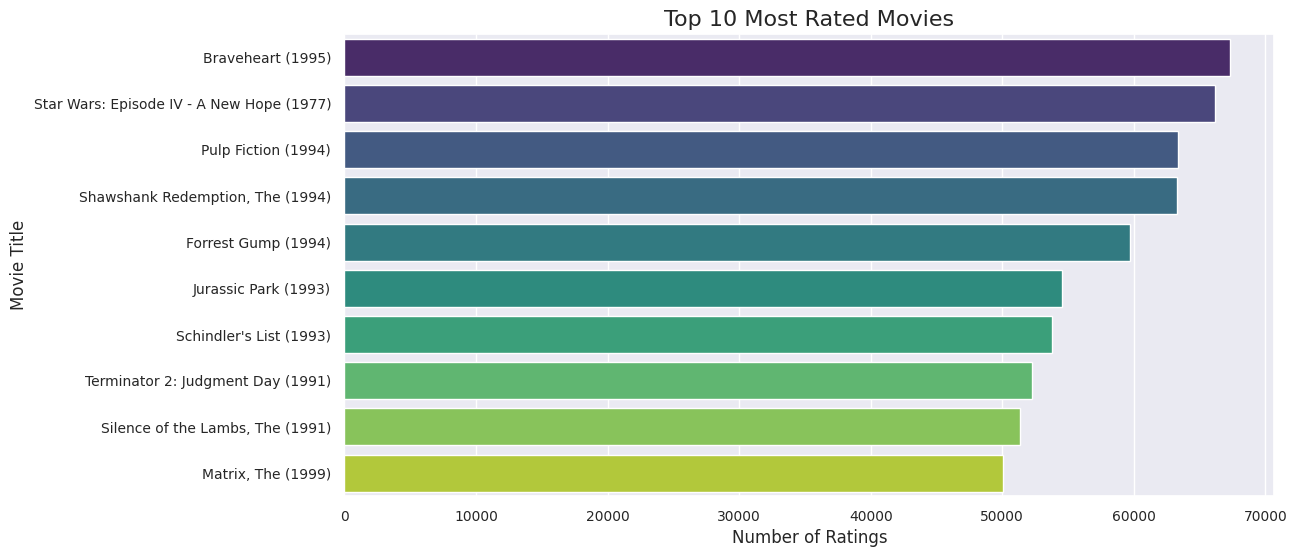

In [ ]:
# Set the theme for consistent visuals
sns.set(style="darkgrid", palette="muted")

# Plot the top 10 most rated movies based on the number of ratings
top_10_most_rated = ratings["movieId"].value_counts().head(10)
top_10_most_rated_movies = movies[movies["movieId"].isin(top_10_most_rated.index)].copy()
top_10_most_rated_movies["num_ratings"] = top_10_most_rated.values

# Plot the top 10 most rated movies
plt.figure(figsize=(12, 6))
sns.barplot(
    x="num_ratings",
    y="title",
    data=top_10_most_rated_movies,
    palette="viridis"
)
plt.xlabel("Number of Ratings", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.title("Top 10 Most Rated Movies", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


# **Conclusion**

In this project, we learned the importance of Recommendation Systems, the types of recommender systems being implemented, and how to use single value decomposition to enhance a system.

We tried generating recommendations based on Collaborative Filtering techniques.

We tried to predict the ratings for movies that the user might give based on its past rating behaviours and measure the accuracy using RMSE error metrics.

Surely, there is huge scope of improvement and tring out different techniques and ML/DL algorithms.